In [21]:
pip install tensorflow opencv-python mediapipe numpy pandas scikit-learn


Note: you may need to restart the kernel to use updated packages.


In [22]:
# Импорт необходимых библиотек
import cv2
import mediapipe as mp
import numpy as np
import os
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# ---------------------------
# 1. Функция для извлечения ключевых точек рук с дополнительными признаками
# ---------------------------
def extract_hand_keypoints(video_path):
    """
    Извлекает ключевые точки рук из видео с помощью Mediapipe Hands.
    Если обнаружено несколько рук, усредняет координаты.
    Добавляет дополнительные признаки:
      - Среднее расстояние от запястья (первой точки) до остальных.
      - Стандартное отклонение этих расстояний.
    Итоговый вектор признаков имеет размер 44 (42 координаты + 2 дополнительных признака).
    """
    mp_hands = mp.solutions.hands
    hands = mp_hands.Hands(static_image_mode=False, max_num_hands=2, min_detection_confidence=0.5)
    all_features = []

    cap = cv2.VideoCapture(video_path)
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Преобразуем кадр в RGB
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = hands.process(frame_rgb)

        if results.multi_hand_landmarks:
            hand_coords = []
            # Собираем координаты для всех обнаруженных рук
            for hand_landmarks in results.multi_hand_landmarks:
                coords = [landmark.x for landmark in hand_landmarks.landmark] + [landmark.y for landmark in hand_landmarks.landmark]
                hand_coords.append(coords)
            # Усредняем координаты, если найдено несколько рук
            avg_coords = np.mean(np.array(hand_coords), axis=0)
        else:
            # Если не найдены руки, заполняем нулями
            avg_coords = np.zeros(42)

        # Вычисляем дополнительные признаки (используем только одну руку, так как avg_coords имеет 42 элемента)
        # Предполагаем, что первые 21 значения – координаты x, следующие 21 – координаты y.
        x_coords = avg_coords[:21]
        y_coords = avg_coords[21:]
        wrist = np.array([x_coords[0], y_coords[0]])
        distances = []
        for i in range(1, 21):
            point = np.array([x_coords[i], y_coords[i]])
            distances.append(np.linalg.norm(point - wrist))
        avg_distance = np.mean(distances)
        std_distance = np.std(distances)

        # Объединяем исходные координаты с дополнительными признаками
        features = np.concatenate([avg_coords, [avg_distance, std_distance]])
        all_features.append(features)
    
    cap.release()
    return np.array(all_features)

# ---------------------------
# 2. Построение датасета
# ---------------------------
# Пути к папкам с видео для двух классов:
healthy_videos = "videos/healthy"
diseased_videos = "videos/tapping"  # Здесь должны быть видео людей с когнитивными нарушениями

data = []
labels = []

# Обработка видео здоровых людей (метка 0)
for video_file in os.listdir(healthy_videos):
    video_path = os.path.join(healthy_videos, video_file)
    keypoints = extract_hand_keypoints(video_path)
    for frame_features in keypoints:
        data.append(frame_features)
        labels.append(0)

# Обработка видео больных (метка 1)
for video_file in os.listdir(diseased_videos):
    video_path = os.path.join(diseased_videos, video_file)
    keypoints = extract_hand_keypoints(video_path)
    for frame_features in keypoints:
        data.append(frame_features)
        labels.append(1)

# Сохранение датасета в CSV
df = pd.DataFrame(data)
df['label'] = labels
df.to_csv("hand_dataset.csv", index=False)
print("Датасет сохранён!")

# ---------------------------
# 3. Подготовка данных для обучения
# ---------------------------
df = pd.read_csv("hand_dataset.csv")
X = df.iloc[:, :-1].values  # Размерность (N, 44)
y = df['label'].values

# Нормализация данных
scaler = StandardScaler()
X = scaler.fit_transform(X)

Датасет сохранён!


Epoch 1/100
198/198 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.7519 - loss: 0.5113 - val_accuracy: 0.9632 - val_loss: 0.1074 - learning_rate: 0.0010
Epoch 2/100
198/198 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9228 - loss: 0.1938 - val_accuracy: 0.9848 - val_loss: 0.0399 - learning_rate: 0.0010
Epoch 3/100
198/198 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9552 - loss: 0.1314 - val_accuracy: 0.9873 - val_loss: 0.0269 - learning_rate: 0.0010
Epoch 4/100
198/198 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9648 - loss: 0.1058 - val_accuracy: 0.9810 - val_loss: 0.0333 - learning_rate: 0.0010
Epoch 5/100
198/198 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9622 - loss: 0.1027 - val_accuracy: 0.9816 - val_loss: 0.0272 - learning_rate: 0.0010
Epoch 6/100
198/198 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9712 - loss: 0.0755 - val_accuracy: 0.9791 - val_loss: 0.0333 - learning_rate: 0.0010
Epoch 7/100
198/198 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9722 - loss: 0.

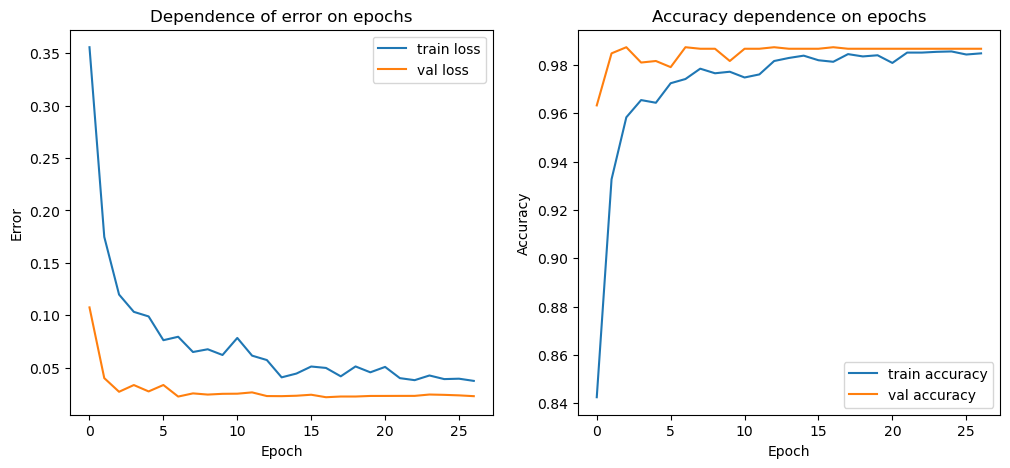

In [23]:
# 1. Подготовка данных (предполагается, что данные уже загружены и нормализованы)
df = pd.read_csv("hand_dataset.csv")
X = df.iloc[:, :-1].values  # Признаки: размер (N, 44)
y = df['label'].values       # Метки классов

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 2. Определение мощной архитектуры модели
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X_train.shape[1],)),

    # Первый скрытый слой
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),

    # Второй скрытый слой
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),

    # Третий скрытый слой
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.4),

    # Четвёртый скрытый слой
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.4),

    # Пятый скрытый слой
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),

    # Выходной слой
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# 3. Колбэки для динамической настройки обучения
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# 4. Обучение модели (увеличено число эпох для длительного обучения)
history = model.fit(
    X_train, y_train,
    epochs=100,             # можно увеличить количество эпох
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop, reduce_lr]
)

# 5. Оценка модели на тестовых данных
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Точность на тестовых данных: {accuracy * 100:.2f}%")

# 6. Построение графиков обучения
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Dependence of error on epochs')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy dependence on epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [24]:
# Предполагается, что функции extract_hand_keypoints и predict_for_video,
# а также обученная модель (model) и нормализатор (scaler) уже определены.

# Функция для предсказания для видео (если её ещё нет в коде)
def predict_for_video(video_path, model, scaler):
    test_keypoints = extract_hand_keypoints(video_path)
    # Удаляем кадры, где нет данных (все нули)
    test_keypoints = [frame for frame in test_keypoints if not np.all(frame == 0)]
    if len(test_keypoints) == 0:
        print("Не удалось извлечь ключевые точки из видео.")
        return None
    test_keypoints = scaler.transform(np.array(test_keypoints))
    predictions = model.predict(test_keypoints)
    avg_prediction = predictions.mean()
    print(f"Среднее предсказание: {avg_prediction:.2f}")
    if avg_prediction > 0.5:
        print("Высокая вероятность когнитивного нарушения")
    else:
        print("Низкая вероятность когнитивного нарушения")
    return avg_prediction

# Ввод пути к видео пользователем
video_path = "healthy_video_1.mp4"

# Получение предсказания
result = predict_for_video(video_path, model, scaler)

# Дополнительная обработка результата (если необходимо)
if result is not None:
    if result > 0.5:
        print("Диагноз: высокая вероятность когнитивного нарушения.")
    else:
        print("Диагноз: низкая вероятность когнитивного нарушения.")


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Среднее предсказание: 0.26
Низкая вероятность когнитивного нарушения
Диагноз: низкая вероятность когнитивного нарушения.


In [30]:
model.save("model.h5")

In [31]:
import joblib
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

In [25]:
video_path = "parkinson_test_1.mp4"
result = predict_for_video(video_path, model, scaler)

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Среднее предсказание: 1.00
Высокая вероятность когнитивного нарушения


In [29]:
video_path = "healthy_test_1.mp4"
result = predict_for_video(video_path, model, scaler)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Среднее предсказание: 0.00
Низкая вероятность когнитивного нарушения


In [27]:
video_path = "parkinson_test_3.mp4"
result = predict_for_video(video_path, model, scaler)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Среднее предсказание: 1.00
Высокая вероятность когнитивного нарушения


In [28]:
video_path = "parkinson_test_4.mp4"
result = predict_for_video(video_path, model, scaler)

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Среднее предсказание: 0.92
Высокая вероятность когнитивного нарушения
